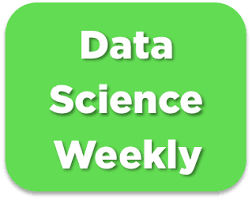

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Read file with labels

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

## Training pipeline

In [6]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)
mask = data["age"] < 70
data = data[mask]

features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'
numeric_indices = [1,3]
categorical_indices = [0,2]

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

numeric_features = ['age', 'total_pages_visited']  # Names of numeric columns in X_train/X_test

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # standardization
])

categorical_features = ['country', 'new_user', 'source',]  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first'))
        # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Set with labels (our train+test) : (284580, 6)


In [7]:
from sklearn.linear_model import LogisticRegression


print("Grid search...")

logreg = LogisticRegression()



params= {
'penalty' : ['l2'],
'C' : np.logspace(-4, 4, 20),
'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
'max_iter' : [2000]
}


gridsearch_logreg = GridSearchCV(logreg, param_grid=params, cv=5, scoring="f1")
                                  # verbose=True)  # cv : the number of folds to be used for CV
gridsearch_logreg.fit(X_train, Y_train)
print("...Done.")

print("Accuracy on training set : ", gridsearch_logreg.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_logreg.score(X_test, Y_test))

# Predictions on training set
Y_train_pred = gridsearch_logreg.predict(X_train)
Y_test_pred = gridsearch_logreg.predict(X_test)

print("Best hyperparameters : ", gridsearch_logreg.best_params_)
print("Best validation accuracy : ", gridsearch_logreg.best_score_)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))


Grid search...
...Done.
Accuracy on training set :  0.7650108965206283
Accuracy on test set :  0.7595013681970204
Best hyperparameters :  {'C': 3792.690190732246, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'sag'}
Best validation accuracy :  0.7648648394516566
f1-score on train set :  0.7650108965206283
f1-score on test set :  0.7595013681970204


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [8]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

gridsearch_logreg.fit(X, Y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [9]:
pred = gridsearch_logreg.predict(X)
print("f1-score on set : ", f1_score(Y, pred))

f1-score on set :  0.7636517226814699


In [10]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [11]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5, :])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30904088  3.32925291  0.          1.          0.          0.
   0.          1.        ]
 [-1.03508199  0.03793998  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17498653 -1.15890108  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17498653  0.33715025  0.          0.          1.          1.
   0.          0.        ]
 [-0.67206144 -0.56048055  0.          0.          0.          0.
   0.          1.        ]]


In [12]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': gridsearch_logreg.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv(f'conversion_data_test_predictions_LV_LogReg-{datetime.datetime.now().timestamp()}.csv', index=False)


NameError: name 'datetime' is not defined

## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**